# IED Detection

This notebook detects IEDs to produce labels for our forecasting algorithms. This includes:
* Loading an EDF file containing the recordings and keeping a defined subset of all channels.
* Running an IED detection algorithm.
* (Early implementation: Grouping IEDs into sequences across channels).
* Splitting the data up into different 'windows' which are then labelled with the number of IEDs that occur in the next window.
* Saving these windows and their labels (X.npy/y.npy).

In [2]:
import mne
import scipy
import scipy.io
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
import math

matplotlib.rcParams['figure.figsize'] = (20, 10)
mne.set_log_level('WARNING')

Open the file containing the recordings.

In [3]:
raw_fname = 'Data/TrialPatientArRa/X~ X_2fc7b4bb-d0f1-45b1-b60d-0ec24a942259.EDF'
# raw_fname = 'Data/TrialPatientBeSa/X~ X_74addeec-ea9c-4b25-8280-cab2db067651.EDF'
# raw = mne.io.read_raw_edf(raw_fname, preload='Data/TrialPatientArRa/temp')

raw = mne.io.read_raw_edf(raw_fname, preload=False)

print(raw.info)

<Info | 7 non-empty values
 bads: []
 ch_names: EEG J12, EEG J11, EEG J10, EEG J9, EEG J8, EEG J7, EEG J6, EEG ...
 chs: 185 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1024.0 Hz
 meas_date: 2020-12-11 14:30:00 UTC
 nchan: 185
 projs: []
 sfreq: 2048.0 Hz
>


In [4]:
# Load file containing suitable channels and convert to list
mat = scipy.io.loadmat('Data/TrialPatientArRa/channels.mat')
valid_channels = [channel[0] for channel in mat['channels'][:, 0]]
# valid_channels = [channel for channel in valid_channels if 'EEG E' in channel]

In [7]:
# first_10_seconds = raw.copy().crop(0, 10).load_data()
# first_10_seconds.set_eeg_reference(ref_channels=['EEG L6'])
# first_10_seconds.plot(duration=10, n_channels=12, scalings=dict(eeg=5e-4))

In [5]:
%run DetectSpike_SEEG.py

Crop recordings hour by hour, detecting IEDs in each.

In [ ]:
# In minutes
BlockSize=60

# Time points
M = raw.n_times

freq = raw.info['sfreq']
ref_channels = ['EEG L6']

SpikeIds = []
ChanIds = []

# Duration of recording in seconds
NumSecs = M / freq
Blocks = math.floor(NumSecs / (BlockSize * 60))

for CurrentBlock in range(Blocks):
    Data = raw.copy().crop(CurrentBlock * BlockSize * 60, \
                           CurrentBlock * BlockSize * 60 + 60 * BlockSize) \
    .load_data() \
    .set_eeg_reference(ref_channels=ref_channels) \
    .get_data(picks=valid_channels)
        
    SpikeIndex, ChanId, _ = DetectSpikes(Data, freq, DetThresholds=[7, 7, 300, 10, 10])
        
    # Add to list across all blocks, corrected for times
    SpikeIds.append(SpikeIndex + CurrentBlock * BlockSize * 60 * freq)
    ChanIds.append(ChanId)

In [131]:
# Convert to numpy arrays
SpikeIndex = np.concatenate(SpikeIds, axis=0)
ChanId = np.concatenate(ChanIds, axis=0)

Alternatively just do this at once.

In [6]:
freq = raw.info['sfreq']
ref_channels = ['EEG L6']

Data = raw.set_eeg_reference(ref_channels=ref_channels).get_data(picks=valid_channels)

SpikeIds, ChanIds, _ = DetectSpikes(Data, freq, DetThresholds=[7, 7, 300, 10, 10])

IED spikes -> IED sequences. If an IED is within 50ms of the start of the current sequence, or 15ms from the last added spike in the sequence, it's added to the sequence.

In [7]:
spikes, chans = SpikeIds.copy(), ChanIds.copy()

spikes_argsort = np.argsort(spikes)
spikes = list(spikes[spikes_argsort])
chans = list(chans[spikes_argsort])

# 50ms and 15ms in indices (using known frequency)
fifty_ms = int(round(freq * 0.05))
fifteen_ms = int(round(freq * 0.015))

# Lists for all sequences, one for spike indices and one for channels
all_seq_spikes = []
all_seq_chans = []

# While there are unprocessed spikes 
while len(spikes) > 0:
    
    # Start a list with the leading spike
    seq_spikes = [spikes.pop(0)]
    seq_chans = [chans.pop(0)]
    
    curr_spike = seq_spikes[0]
    
    # For remaining spikes
    for spike in spikes:
        # If spike is within 15ms of last spike in sequence or 50ms of first
        if spike - seq_spikes[0] <= fifty_ms or spike - curr_spike <= fifteen_ms:
            # Then add to sequence
            curr_spike = spike
            
            seq_spikes.append(spikes.pop(0))
            seq_chans.append(chans.pop(0))
            
        # When no more eligible spikes, move to next sequence
        else:
            break
            
    # Add processed sequence to list of sequences
    all_seq_spikes.append(seq_spikes)
    all_seq_chans.append(seq_chans)

Just for fun, work out the most common routes from A -> B using two separate methods. One only counts B if it's the terminus of the sequence, one counts it as long as B is in the sequence at all.

In [128]:
# If a sequence is A -> B -> C, count A -> B as one connection and B -> C as another.
starts_list = [chan[:-1] for chan in all_seq_chans if len(chan) >= 2]
ends_list = [chan[1:] for chan in all_seq_chans if len(chan) >= 2]

pairs = []

for starts, ends in zip(starts_list, ends_list):
    for start, end in zip(starts, ends):
        pairs.append([int(start), int(end)])

unique, counts = np.unique(pairs, return_counts=True, axis=0)

sorted_counts = np.flip(np.argsort(counts))
counts = counts[sorted_counts[:20]]
unique = unique[sorted_counts[:20]]

for u, c in zip(unique, counts):
    print(c, valid_channels[u[0]], '->', valid_channels[u[1]])

810 EEG J1 -> EEG J2
575 EEG I3 -> EEG I4
502 EEG I2 -> EEG I3
490 EEG I4 -> EEG I5
451 EEG J2 -> EEG J3
432 EEG N3 -> EEG N2
344 EEG I3 -> EEG I2
310 EEG J3 -> EEG J4
213 EEG I4 -> EEG I3
212 EEG J11 -> EEG J12
212 EEG N8 -> EEG N9
205 EEG N2 -> EEG N3
201 EEG J11 -> EEG J10
173 EEG J7 -> EEG J6
173 EEG N9 -> EEG N8
168 EEG J12 -> EEG J11
155 EEG J10 -> EEG J11
139 EEG J10 -> EEG J9
134 EEG I5 -> EEG I4
128 EEG J5 -> EEG J6


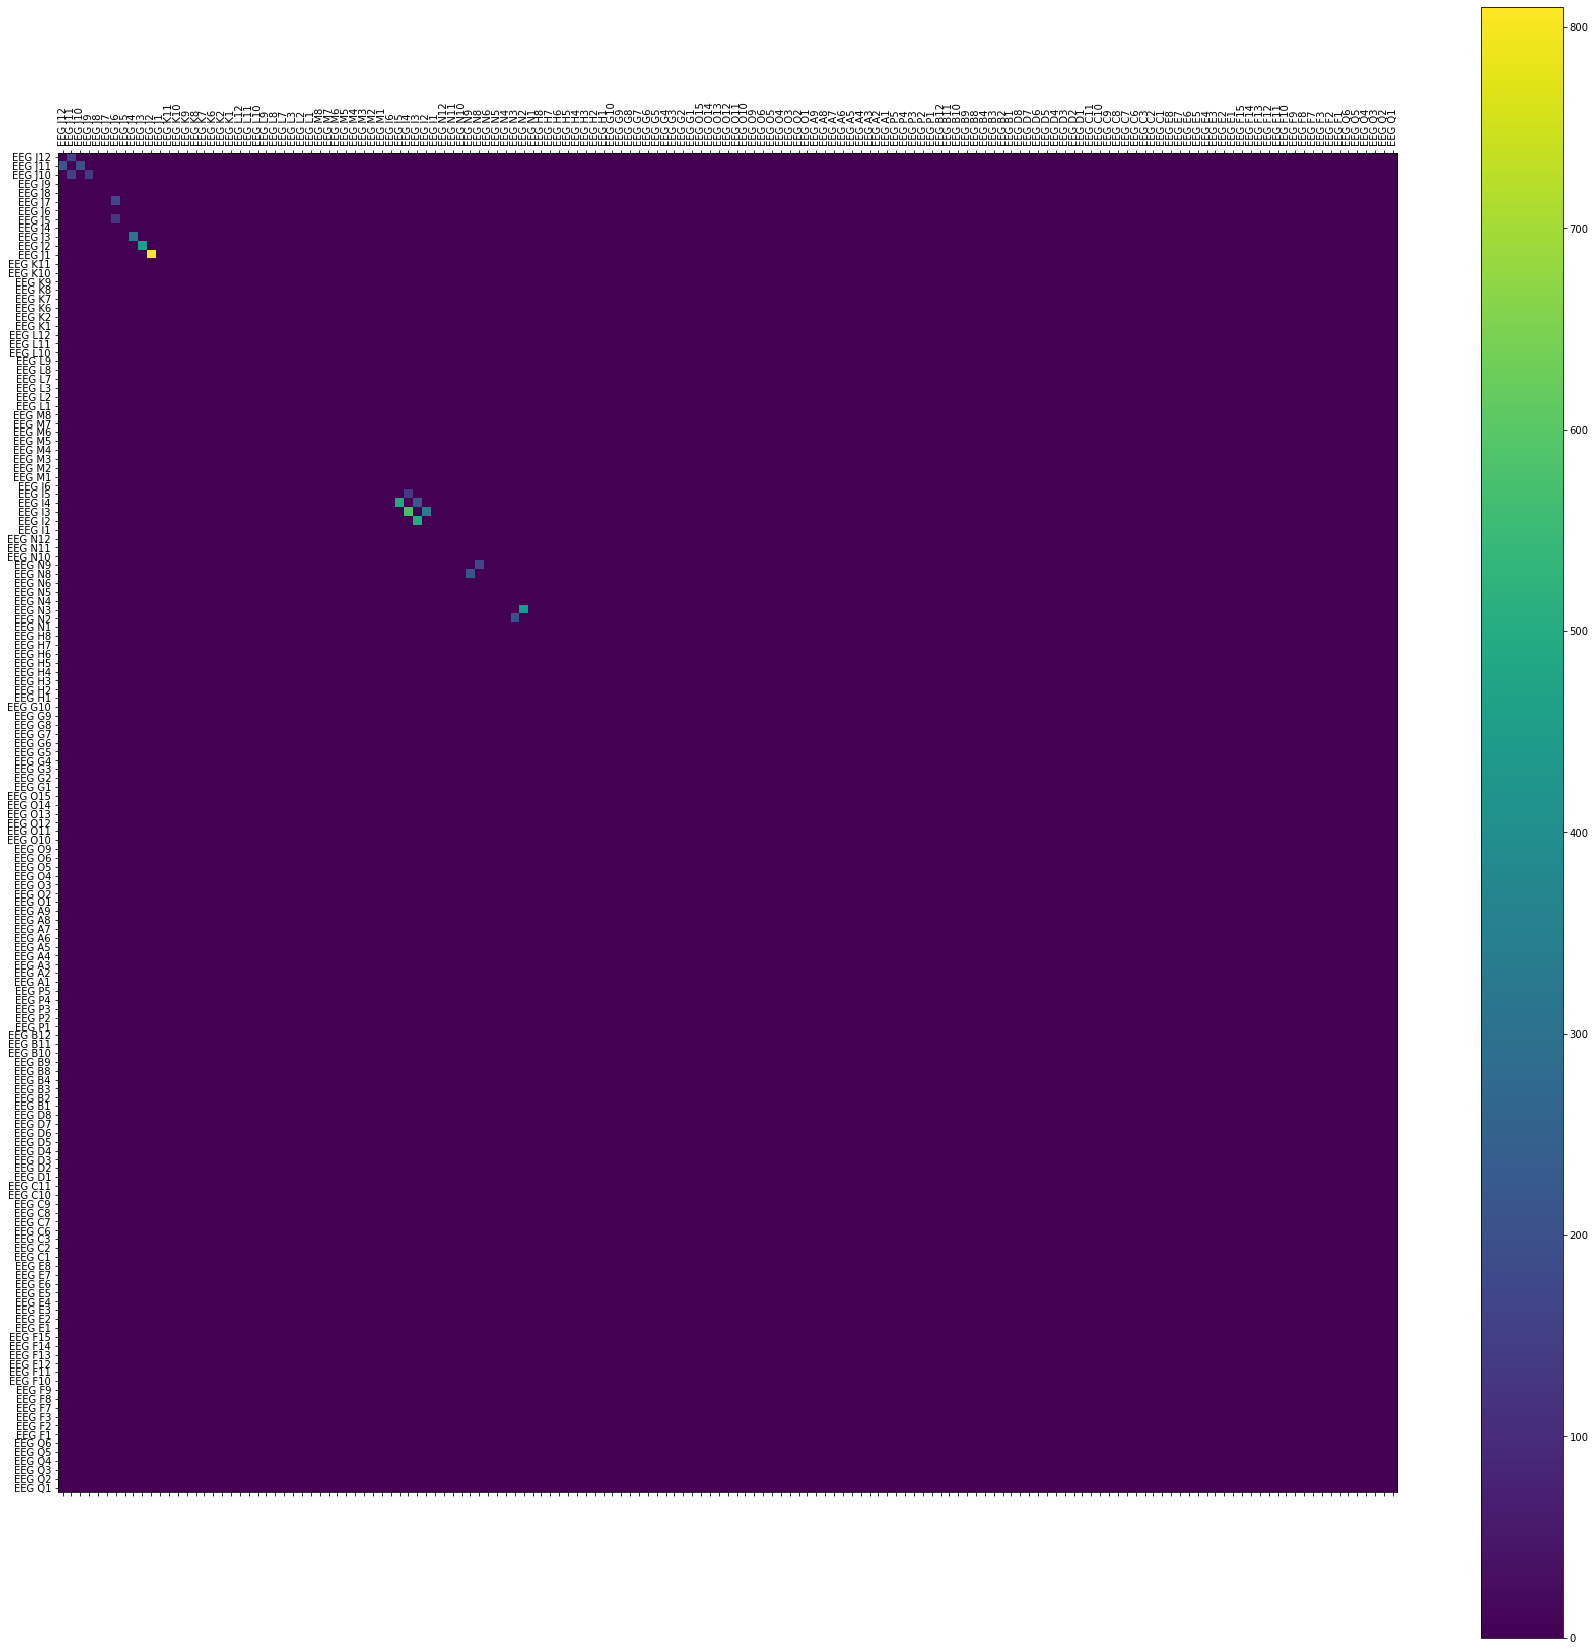

In [130]:
import scipy.stats as stats

matplotlib.rcParams['figure.figsize'] = (30, 30)

chans = 151

# counts
# unique
counts_mat = np.zeros((151, 151))
for c, u in zip(counts, unique):
    counts_mat[u[0]][u[1]] = c

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(counts_mat[:chans, :chans], interpolation='nearest')
fig.colorbar(cax)

xaxis = np.arange(chans)
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(valid_channels[:chans], rotation=90)
ax.set_yticklabels(valid_channels[:chans])

plt.show()

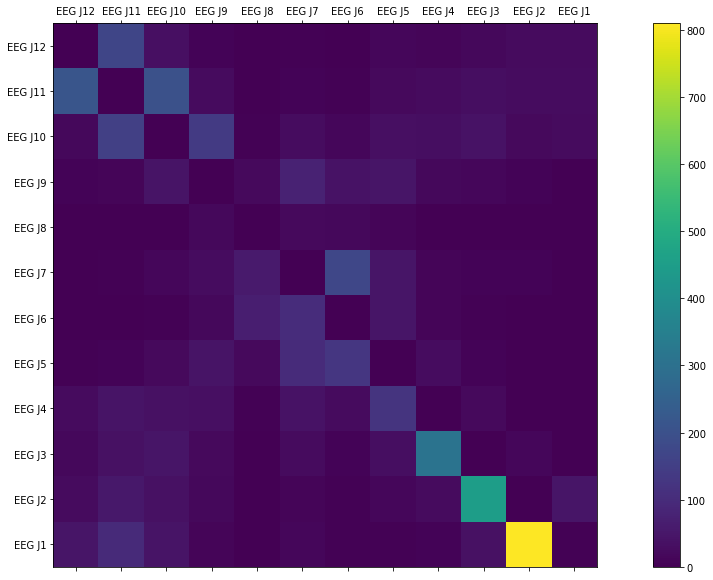

In [82]:
# counts
# unique
counts_mat = np.zeros((151, 151))
for c, u in zip(counts, unique):
    counts_mat[u[0]][u[1]] = c

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(counts_mat[:12, :12], interpolation='nearest')
fig.colorbar(cax)

xaxis = np.arange(12)
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(valid_channels[:12])
ax.set_yticklabels(valid_channels[:12])

plt.show()

In [104]:
# If a sequence is A -> B -> C, count A -> C as one connection only.
start_list = [chan[0] for chan in all_seq_chans if len(chan) >= 2]
end_list = [chan[-1] for chan in all_seq_chans if len(chan) >= 2]

pairs = []

starts
for start, end in zip(start_list, end_list):
    pairs.append([int(start), int(end)])

unique, counts = np.unique(pairs, return_counts=True, axis=0)

sorted_counts = np.flip(np.argsort(counts))
counts = counts[sorted_counts[:20]]
unique = unique[sorted_counts[:20]]

for u, c in zip(unique, counts):
    print(c, valid_channels[u[0]], '->', valid_channels[u[1]])

286 EEG J1 -> EEG J2
246 EEG I4 -> EEG I5
185 EEG I3 -> EEG I4
170 EEG I3 -> EEG I2
142 EEG I2 -> EEG I3
121 EEG N3 -> EEG I3
115 EEG I2 -> EEG I4
106 EEG N8 -> EEG N9
95 EEG J1 -> EEG J3
89 EEG N3 -> EEG I2
85 EEG E2 -> EEG E3
79 EEG E3 -> EEG O15
77 EEG N9 -> EEG N10
74 EEG N9 -> EEG N8
73 EEG E3 -> EEG E2
73 EEG O15 -> EEG E2
71 EEG J1 -> EEG J4
70 EEG N3 -> EEG N2
68 EEG E3 -> EEG E3
67 EEG N3 -> EEG I4


[Text(0.5, 0, 'IED sequence duration (ms)')]

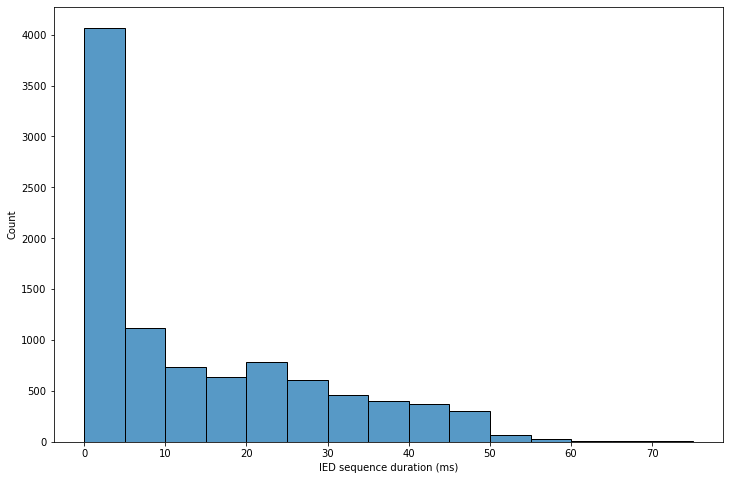

In [127]:
matplotlib.rcParams['figure.figsize'] = (12, 8)

length_list = [(1000/2048) * (spike[-1] - spike[0]) for spike in all_seq_spikes if len(spike) > 1]

ax = sns.histplot(length_list, bins=15, binrange=[0, 75])
ax.set(xlabel='IED sequence duration (ms)')

Histogram of when sequences occur.

/Users/jamienorris/miniconda3/envs/diss/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)


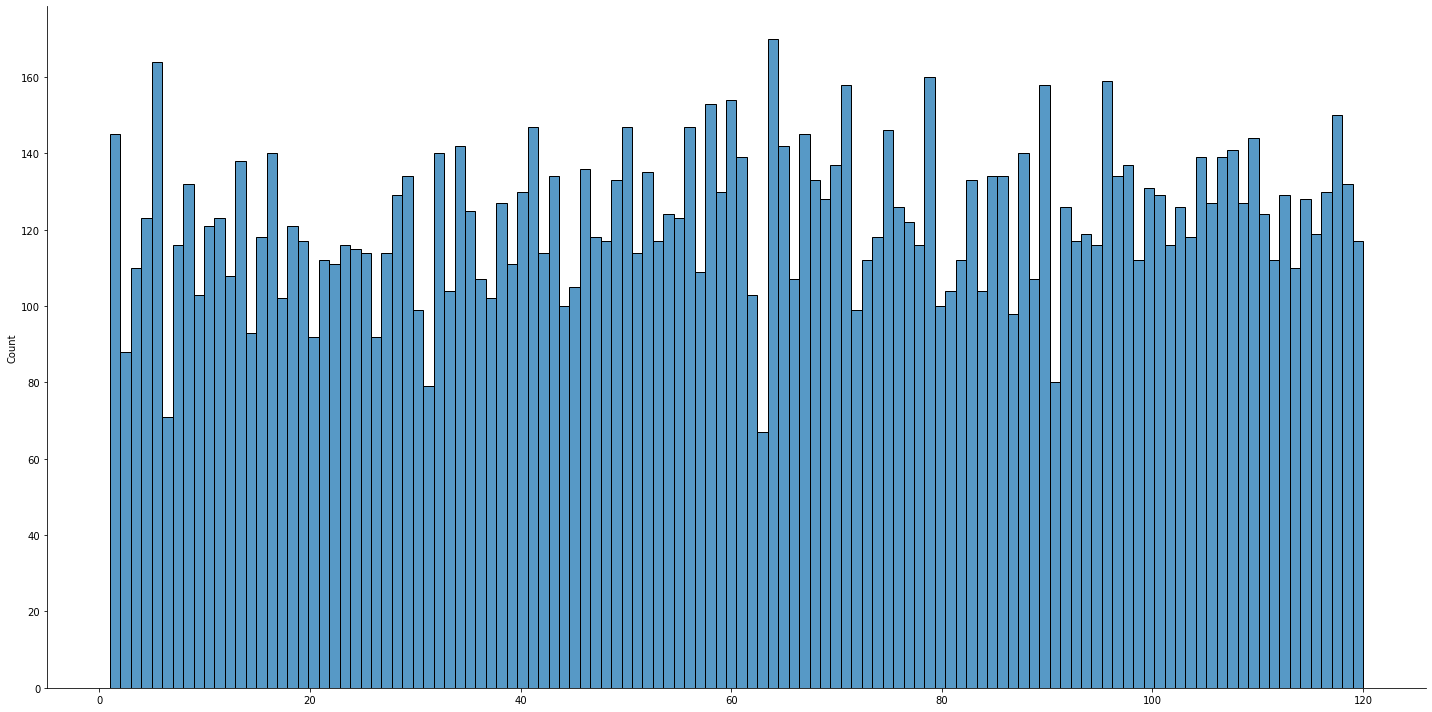

In [212]:
# all_seq_spikes, all_seq_chans
# If 5 or more spikes are in the sequence.
# sequence_starts = [spike[0] for spike in all_seq_spikes if len(spike) >= 2]
sequence_starts = [spike[0] for spike in all_seq_spikes]

bins = np.arange(0, 3600, 30)
# dig = np.digitize(SpikeIds[ChanIds == 3] / 2048, bins)
dig = np.digitize(np.array(sequence_starts) / 2048, bins)
# sns.displot(dig, kind='kde')
sns.displot(dig, bins=len(bins), height=10, aspect=2)

All IED spikes.

/Users/jamienorris/miniconda3/envs/diss/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)


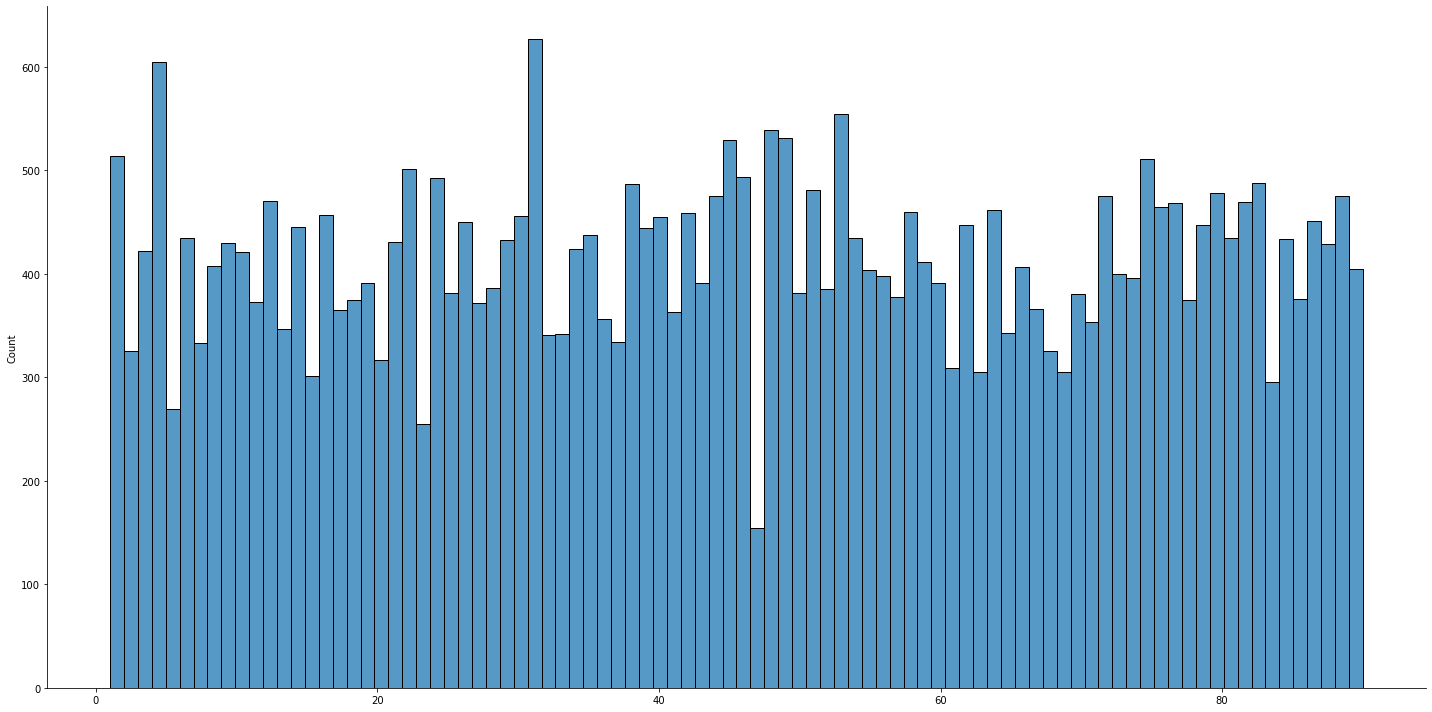

In [209]:
bins = np.arange(0, 3600, 40)
# dig = np.digitize(SpikeIds[ChanIds == 3] / 2048, bins)
dig = np.digitize(SpikeIds / 2048, bins)
# sns.displot(dig, kind='kde')
sns.displot(dig, bins=len(bins), height=10, aspect=2)

Plot some data and detected IEDs.

/Users/jamienorris/miniconda3/envs/diss/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)


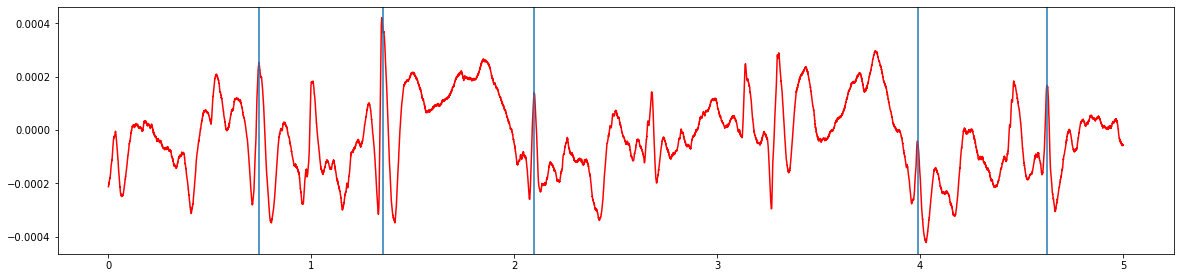

In [106]:
# How many seconds from the start of the recording to consider
seconds = 5

# Index of channel to consider
chan = 1

t = np.linspace(0.0, seconds, seconds*2048)

# Plot recording
plt.subplot(212)
plt.plot(t, Data[chan, :seconds*2048], color = 'r')

spike_indices = np.logical_and(ChanIds == chan, SpikeIds < seconds*2048)
for spike in SpikeIds[spike_indices]:
    plt.axvline((spike)/2048)

Plot distribution of inter-IED intervals.

Text(0.5, 6.79999999999999, 'Time (s)')

/Users/jamienorris/miniconda3/envs/diss/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)


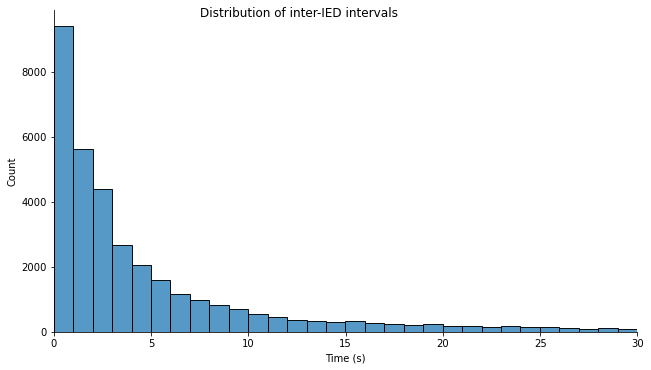

In [115]:
# Difference in time between IEDs
diffs = np.zeros((1))
for channel in np.unique(ChanIds):
    diffs = np.append(diffs, np.diff(SpikeIds[ChanIds == channel]))

diffs = diffs[1:]

# Only keep intervals < 30s
filtered_diffs = diffs[diffs / 2048 < 30]

# Plot using histogram
g = sns.displot(filtered_diffs/2048, bins=30)

# Alternatively use kde plot
# g = sns.displot(filtered_diffs/2048, kind='kde')

g.fig.set_size_inches(10,5)
g.set(xlim=(0, 30))
g.fig.suptitle('Distribution of inter-IED intervals')
plt.xlabel('Time (s)')

Create our dataset from the labels.

In [ ]:
# In Hz
freq = 2048

# How long (in seconds) our windows are
window_seconds = 10

X = []
y = []

for channel, to_split in enumerate(-Data):
    
    # number of windows
    windows = math.floor(to_split.shape[0] / (freq*window_seconds))

    # crop data and reshape to windowed dimension
    new_data = to_split[:freq*window_seconds*windows].reshape((windows, freq*window_seconds))

    # get rid of last X window 
    new_data = new_data[:-1]

    labels = np.zeros(windows)

    for spike in SpikeIndex[ChanId == channel]:
        labels[int(spike // (freq*window_seconds))] += 1

    # get rid of first label
    labels = labels[1:]
    
    # Multiplying by 1e5 and converting to float16 to save space
#     X.append((1e5 * new_data).astype(np.float16))
    X.append(new_data.astype(np.float16))
    y.append(labels)
    
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

Save as X.npy and y.npy

In [12]:
with open('X.npy', 'wb') as f:
    np.save(f, X)
    
with open('y.npy', 'wb') as f:
    np.save(f, y)